In [35]:
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
import warnings
warnings.filterwarnings('ignore')


class VARIMAX(VARMAX):
    def __init__(self, *args, **kwargs):
        endog = args[0]
        args = args[1:]
        k = endog.shape[1]

        if 'order' in kwargs:
            p, d, q = kwargs.pop('order')
            kwargs['order'] = (p, q)
        else:
            p, d, q = 1, 0, 0
        # getting d-th difference if needed. Set first d rows to zeros (discussable)
        if d > 0:
            assert endog.shape[0] > d, 'd = {} is too big for endog with len of {}'.format(
                d, endog.shape[0])
            endog_diff = np.ndarray(endog.shape, dtype=float)
            endog_diff[:d, :] = np.zeros((d, k))
            endog_diff[d:, :] = np.diff(endog, axis=0, n=d)
            endog = endog_diff
            self.__endog_diffed = endog
        super().__init__(endog, *args, **kwargs)

    def get_diff_endog(self):
        # return original endog values
        return self.__endog_diffed

In [43]:
def get_orig_ts(orig_ts, diffed_fcst, d):
    # in case if start_val has shape (1, k) -> set it to (k, )
    k = orig_ts.shape[1]
    n = diffed_fcst.shape[0]
    assert diffed_fcst.shape[1] == k
    
    if d > 0:
        for i in range(d):
            # iteratively diffirentiating original series to get start value;
            # build iteratively ts^(n-1) form ts^(n) and start_val until n-1 == 0
            start_val = np.diff(orig_ts, axis=0, n=d-i-1)[-1]
            res = np.ndarray((n, k))
            res[0] = start_val + diffed_fcst[0]
            for i in range(1, n):
                res[i] = res[i-1] + diffed_fcst[i]
            diffed_fcst = res
        return res
    else:
        return diffed_fcst

In [30]:
data_len = 100
data_dim = 3

# generating 3 time series with linear trend and some noise
ts = np.random.normal(size=(data_len, data_dim), scale=1) + np.transpose([0.1*np.arange(data_len),
                                                                          0.1*np.arange(data_len) + 10,
                                                                          0.1*np.arange(data_len) + 20])

# order = (p, d, q); 'd' is for 'diff order' to remove some trends
vmx = VARIMAX(ts, order=(2, 1, 0))

In [31]:
# fittng time series
model = vmx.fit()

In [32]:
# forecasting...
forecast_len = 10
forecast_res = model.get_forecast(forecast_len)

In [33]:
# confidence intervals, if needed:
forecast_res.conf_int()

,lower y1,lower y2,lower y3,upper y1,upper y2,upper y3
0,-3.945912,-1.053132,-1.990318,0.738014,3.161297,2.403993
1,-2.079020,-2.481335,-2.267782,3.665577,2.989561,2.834721
2,-2.831006,-3.381213,-2.654501,3.075007,2.336163,2.476314
3,-3.162259,-2.294051,-2.363914,2.803029,3.471464,2.789657
4,-2.712050,-3.019455,-2.513545,3.274196,2.826356,2.662310
5,-2.960595,-2.888329,-2.510418,3.031484,3.000298,2.670946
6,-2.937970,-2.743340,-2.454244,3.057561,3.151026,2.727605
7,-2.866560,-2.939510,-2.512380,3.129806,2.955961,2.670002
8,-2.934787,-2.826979,-2.482561,3.061731,3.071188,2.700270
9,-2.905319,-2.848452,-2.484968,3.091446,3.050976,2.697987


(50, 110)

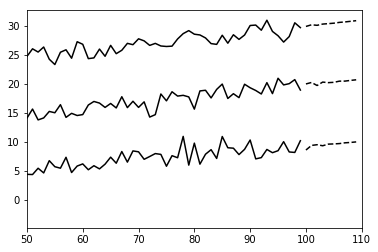

In [34]:
# restore predictions for original time series from its differences
predicted_ts = get_orig_ts(ts, forecast_res.predicted_mean, d=1)

# plotting restored forecast & original data
import matplotlib.pyplot as plt
plt.plot(np.arange(data_len), ts, c='black')
plt.plot(np.arange(forecast_len) + data_len, predicted_ts, '--', c='black')
plt.xlim(data_len - 50, data_len + forecast_len)

In [37]:
import pandas as pd
df = pd.read_csv('~/Downloads/3648.csv')
def eliminate_null_days(df):
    null_rows = [index for index, row in df.iterrows() if not row[1:].any()]
    df.drop(null_rows, inplace=True)
eliminate_null_days(df)